In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

#models
import shiftNMF_frozen as Hybrid
import shiftNMFDiscTau as DiscTau
import torchNMF as standard

from helpers.generators import *

In [25]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 7, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

#W = np.random.rand(N, d)
shift = 500
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
tau[W==0] = 0
#set tau to 0 where W is 0

# tau = np.zeros((N,d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [2000, 5000, 8000]
std = [100, 300, 50]
t = np.arange(0, 10000, 1)

H = np.array([multiplet(t, 1, m, s, 100) for m, s in list(zip(mean, std))])
# H_lorentz = np.array([m(m, s, t) for m, s in list(zip(mean, std))])
H_duplet = np.array([multiplet(t, 2, m, s, 1000) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)
# X_lorentz = shift_dataset(W, H_lorentz, tau)
X_duplet = shift_dataset(W, H_duplet, tau)


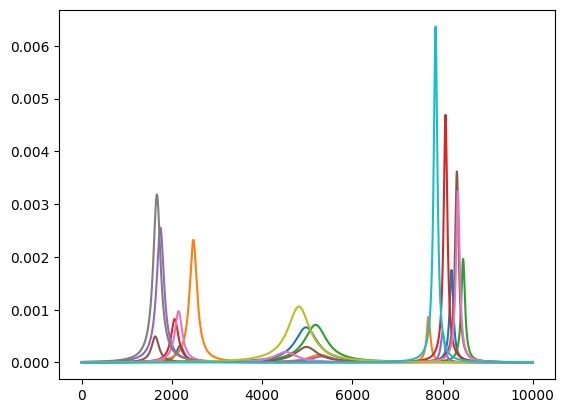

In [26]:
plt.plot(X.T)
plt.show()

In [27]:
# print('Fitting Standard NMF')
# NMF = standard.NMF(X, 3, lr=0.1, alpha=1e-6)
# _,_, running_loss = NMF.fit(verbose=True, return_loss=True)

# print('\n Fitting Discrete Tau NMF')
# discTau = DiscTau.ShiftNMF(X, 3, lr=0.1, alpha=1e-6, patience = 1000)
# W_disc,H_dics,_, running_loss_disc = discTau.fit(verbose=True, return_loss=True, max_iter=750, tau_iter=0)

print('\n Fitting Hybrid NMF')
hybrid = Hybrid.ShiftNMF(X, 3, lr=0.3, alpha=1e-6, patience=1000, min_imp=0)
W_hyb,H_hyb,tau_hyb, running_loss_hybrid = hybrid.fit(verbose=True, return_loss=True, max_iter=1000, tau_iter=0, Lambda=100)

#set tau to 0 if the W is 0
tau_hyb = np.where(W_hyb == 0, 0, tau_hyb).real


 Fitting Hybrid NMF
epoch: 1000, Loss: 0.0036924113726002155, Tau: 2789.1989889572237


In [28]:
# plt.plot(running_loss_hybrid, label='Hybrid')
# plt.plot(running_loss_disc, label='Discrete Tau')
# plt.show()

In [29]:
# disc_rec = np.dot(W_disc, H_dics)
# hyb_rec = np.dot(W_hyb, H_hyb)

# #plot reconstructions without shifts
# fig, ax = plt.subplots(3, 1, figsize=(10, 10))
# ax[0].plot(X.T)
# ax[0].set_title('Original signals')
# ax[1].plot(disc_rec.T)
# ax[1].set_title('Discrete Tau NMF')
# ax[2].plot(hyb_rec.T)
# ax[2].set_title('Hybrid NMF')



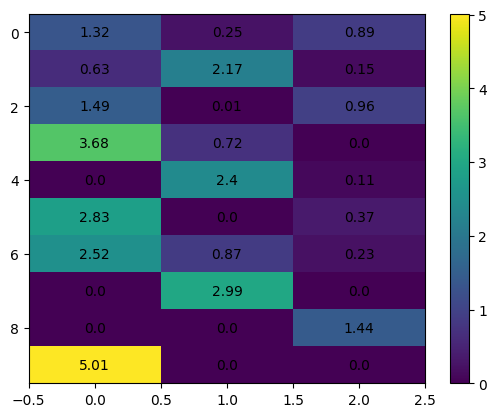

In [30]:
#open plot window like outside of jupyter
plt.imshow(W_hyb, aspect='auto')
plt.colorbar()
#print value on top of each bar
for i in range(W_hyb.shape[0]):
    for j in range(W_hyb.shape[1]):
        plt.text(j, i, round(W_hyb[i,j],2), ha='center', va='center', color='black')
plt.show()

In [31]:
import latent_model_comparison as lmc

In [32]:
model_comp = lmc.LatentModelComparer(true_factor=W, est_factor=W_hyb+10**-9)
col, cor = model_comp.match(type=("greedy"))

#reoder columns of W and rows of H to match col
W_reorder = W_hyb.T[col]
W_reorder = np.squeeze(W_reorder).T

H_reorder = H_hyb[col]
H_reorder = np.squeeze(H_reorder)

tau_reorder = tau_hyb.T[col]
tau_reorder = np.squeeze(tau_reorder).T

# # get tau of columns in col
# tau_hyb = tau_hyb[col]
# #reshape to collapse dimensions of size 1
# tau_hyb = np.squeeze(tau_hyb).T

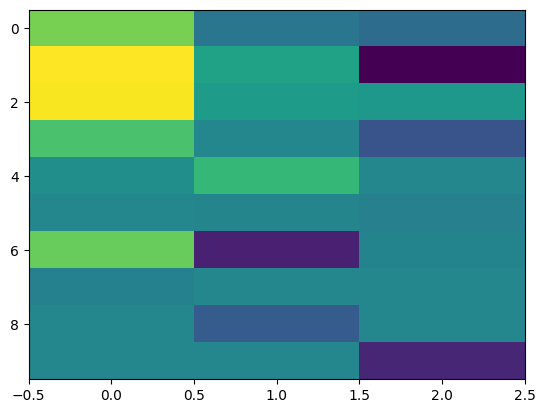

In [33]:
plt.imshow(tau_reorder, aspect='auto')
plt.show()

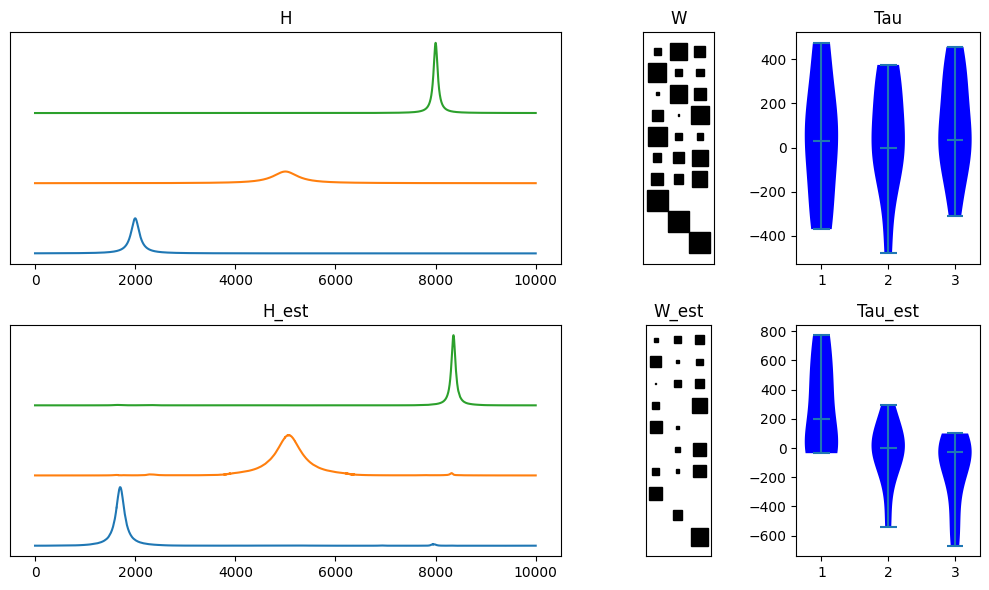

In [34]:
def plotSpaced(ax,x,y):
    ymax = y.max()
    yoffset = ymax
    for i in range(y.shape[1]):
        ax.plot(x,y[:,i]+yoffset*i)

    ax.set_yticks([])

def change_violin_colors(violin_parts, color_list):
    for pc, linecolor in zip(violin_parts["bodies"], color_list):
        pc.set_facecolor(linecolor)
        pc.set_alpha(1)


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'black' if w > 0 else 'white'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()



# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax0 = plt.subplot(gs[0, 0])
plotSpaced(ax0, np.arange(H.shape[1]), H.T)
ax0.set_title('H')

ax1 = plt.subplot(gs[1, 0])
plotSpaced(ax1, np.arange(H_reorder.shape[1]), H_reorder.T)
ax1.set_title('H_est')

# Make hinton plots
ax2 = plt.subplot(gs[0, 1])
ax2.set_title('W')
hinton(W.T, ax=ax2)

ax3 = plt.subplot(gs[1, 1])
ax3.set_title('W_est')
hinton(W_reorder.T, ax=ax3)

# Make violin plots
ax4 = plt.subplot(gs[0, 2])
violin_parts = ax4.violinplot(tau, showmeans=False, showmedians=True)
ax4.set_title('Tau')
change_violin_colors(violin_parts, ['blue']*3)

ax5 = plt.subplot(gs[1, 2])
violin_parts = ax5.violinplot(tau_reorder, showmeans=False, showmedians=True)
ax5.set_title('Tau_est')
change_violin_colors(violin_parts, ['blue']*3)

# Set tight layout
plt.tight_layout()
plt.show()